In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from ipywidgets import (
    VBox, HBox, Button, Layout, Dropdown, FloatSlider, FloatText,
    HTML, DatePicker, SelectMultiple, ToggleButtons, Checkbox, Label
)

from scipy.optimize import minimize

TRADING_DAYS = 252



In [2]:
def fetch_prices(tickers, start, end):
    """Download adjusted close prices for tickers from Yahoo Finance."""
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(df, pd.Series):
        df = df.to_frame()
    return df.dropna(how="all")

def compute_returns(prices, log=True):
    if log:
        rets = np.log(prices / prices.shift(1)).dropna(how="any")
    else:
        rets = prices.pct_change().dropna(how="any")
    return rets

def annualize_vol(returns):
    return returns.std() * np.sqrt(TRADING_DAYS)

def annualize_ret(returns):
    mean_daily = returns.mean()
    return (1 + mean_daily)**TRADING_DAYS - 1

def max_drawdown(equity_curve):
    running_max = equity_curve.cummax()
    drawdown = equity_curve / running_max - 1.0
    return drawdown.min(), drawdown

def beta_vs_market(returns, market_returns):
    cov = np.cov(returns, market_returns)[0,1]
    mvar = np.var(market_returns)
    return cov / mvar if mvar != 0 else np.nan

def var_cvar(returns, alpha=0.95):
    """Historical VaR/CVaR on portfolio daily returns (pd.Series)."""
    q = returns.quantile(1 - alpha)
    cvar = returns[returns <= q].mean()
    return q, cvar

def portfolio_stats(weights, cov, mean_ret=None, rf=0.0):
    w = np.array(weights)
    vol = np.sqrt(w @ cov.values @ w) * np.sqrt(TRADING_DAYS)
    ret = None
    sharpe = None
    if mean_ret is not None:
        ann_ret = (1 + mean_ret.values @ w)**TRADING_DAYS - 1
        ret = ann_ret
        rf_ann = (1 + rf/TRADING_DAYS)**TRADING_DAYS - 1 if rf < 1 else rf
        sharpe = (ann_ret - rf_ann) / vol if vol != 0 else np.nan
    return vol, ret, sharpe

def min_variance_weights(cov):
    """Min-variance (no shorting)."""
    n = cov.shape[0]
    x0 = np.ones(n) / n
    bounds = [(0.0, 1.0)] * n
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    obj = lambda w: w @ cov.values @ w
    res = minimize(obj, x0=x0, bounds=bounds, constraints=cons, method="SLSQP")
    return res.x

def max_sharpe_weights(mean_daily, cov, rf=0.0):
    """Maximise daily Sharpe (no shorting)."""
    n = cov.shape[0]
    x0 = np.ones(n) / n
    bounds = [(0.0, 1.0)] * n
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)

    def neg_sharpe(w):
        vol = np.sqrt(w @ cov.values @ w)
        er = mean_daily.values @ w - rf/252.0
        return -er / vol if vol != 0 else 1e6

    res = minimize(neg_sharpe, x0=x0, bounds=bounds, constraints=cons, method="SLSQP")
    return res.x

def risk_contribution(weights, cov):
    w = np.array(weights)
    sigma = np.sqrt(w @ cov.values @ w)
    mrc = (cov.values @ w) / sigma            # marginal
    prc = w * mrc / sigma                     # percentage
    return pd.DataFrame({"Weight": w, "MRC": mrc, "PRC": prc}, index=cov.index)

def to_equity_curve(returns):
    return (1 + returns).cumprod()


HTML(value='')

HTML(value='<h3>Portfolio Metrics</h3>')

,Annual Return,Annual Volatility,Sharpe,Max Drawdown,VaR (α=0.950),CVaR (α=0.950),Beta vs Market
0,0.3620,0.2330,1.4670,-0.2735,-0.0235,-0.0314,1.2535


HTML(value='<hr/>')

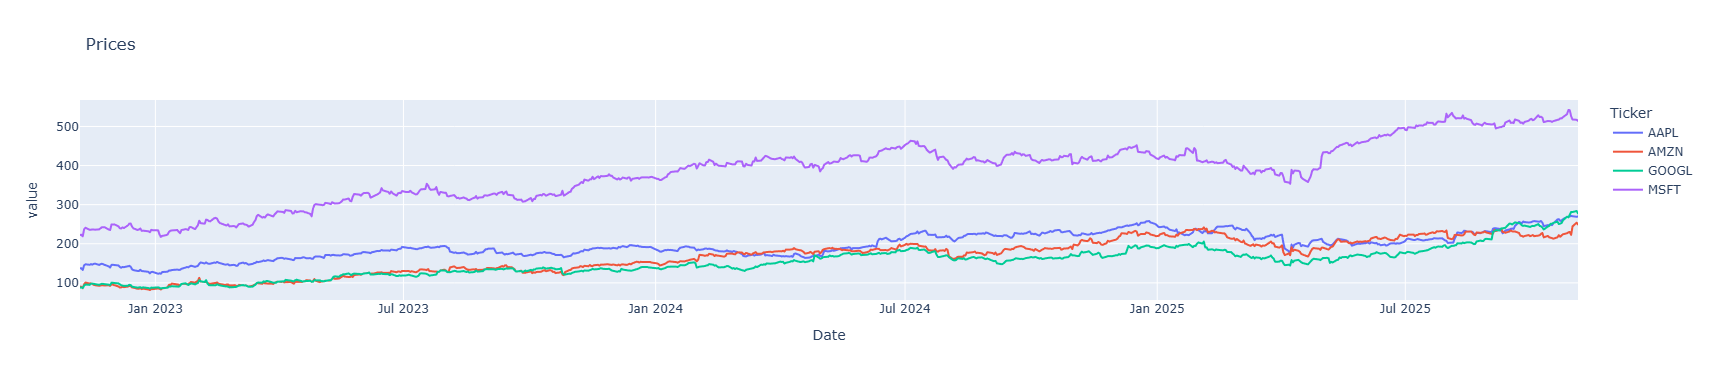

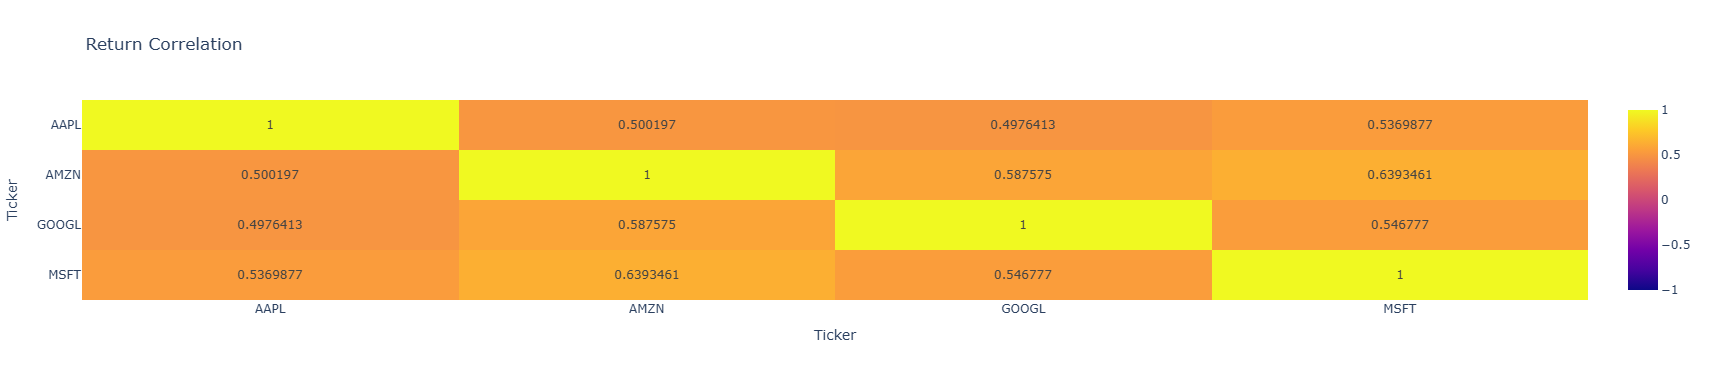

HTML(value='<b>Weights</b>')

Ticker,AAPL,AMZN,GOOGL,MSFT
Weight,0.250,0.250,0.250,0.250


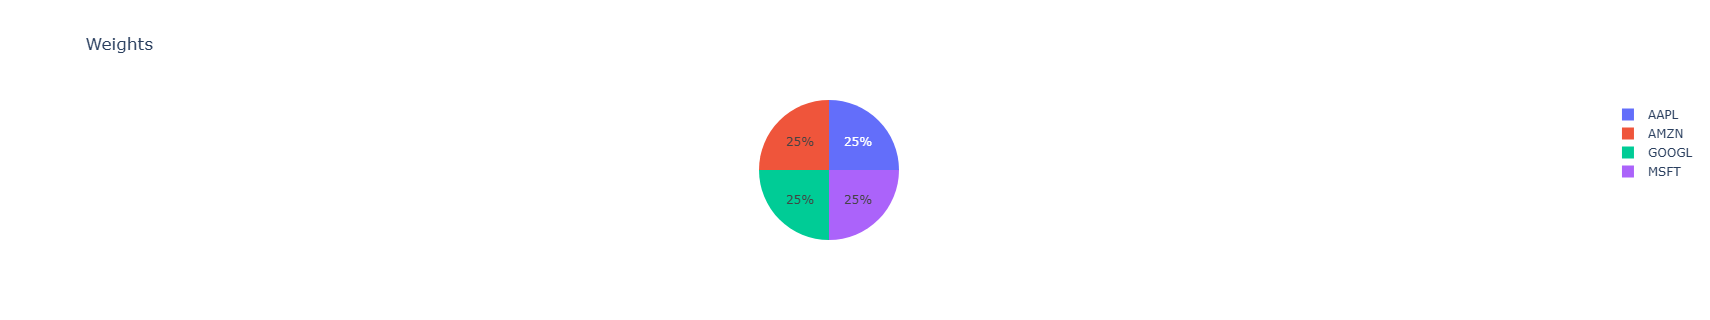

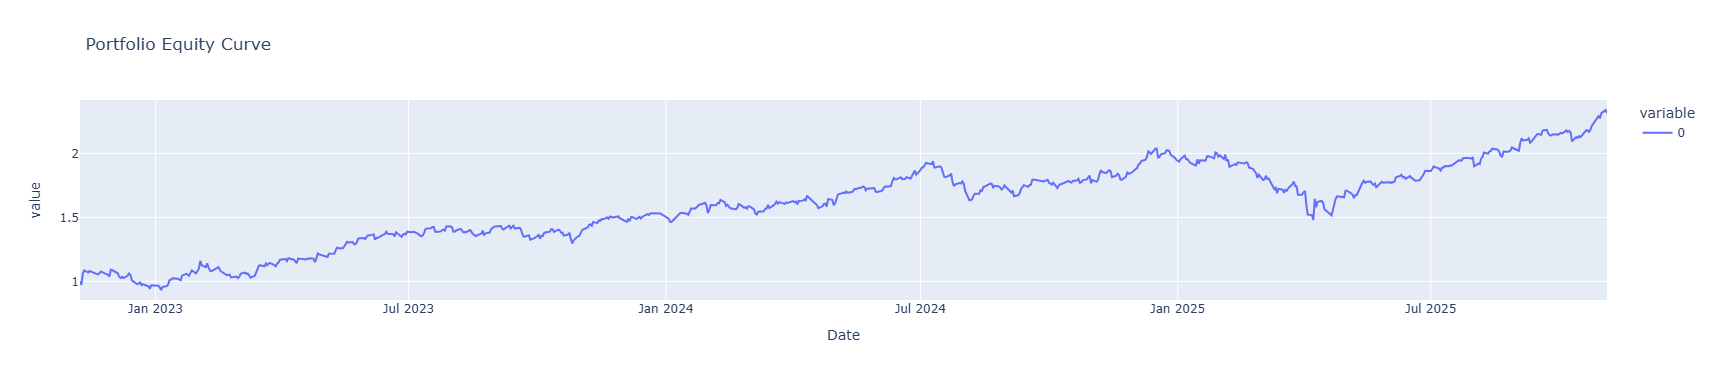

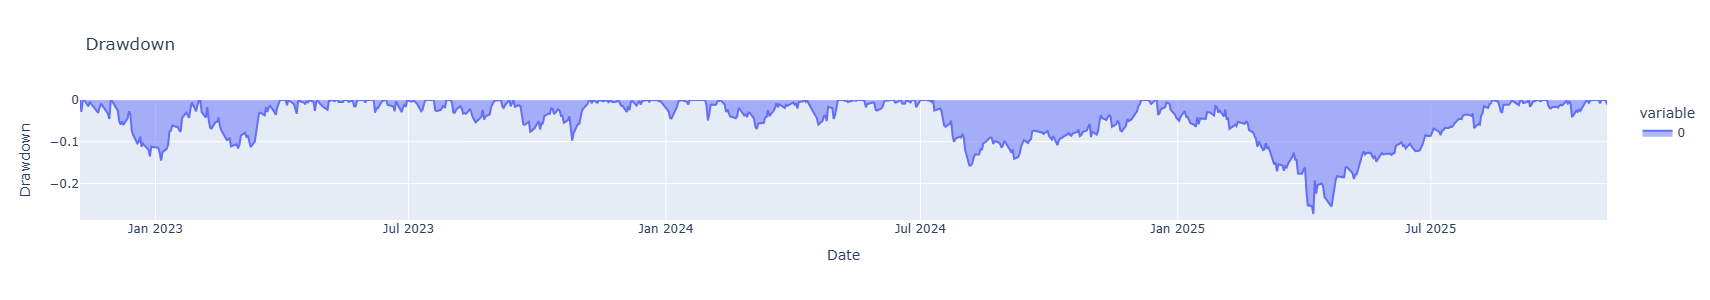

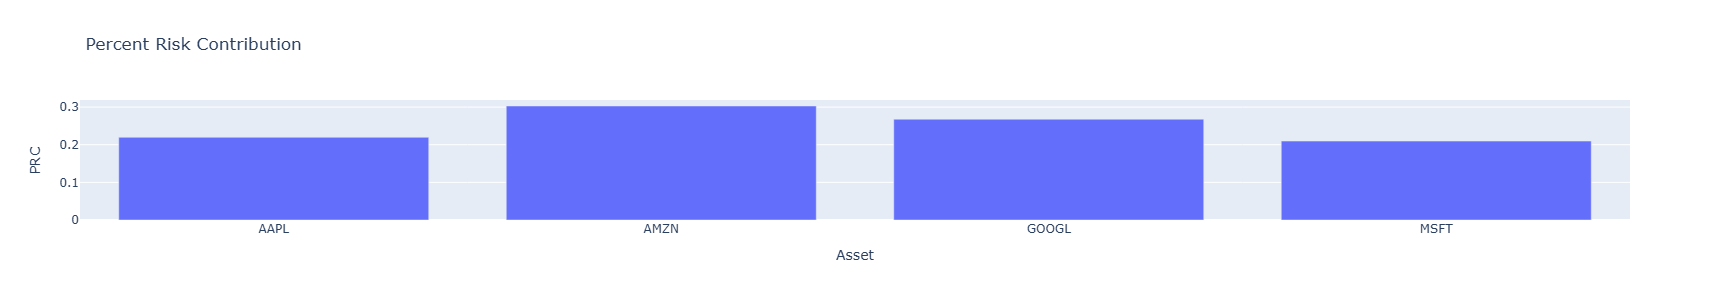

In [3]:
# ---- Default settings ----
default_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA"]  # add '.L' for London, e.g. 'VOD.L'
market_proxy = "^GSPC"  # S&P 500; for FTSE 100 use "^FTSE"
default_start = datetime.now() - timedelta(days=365*3)
default_end = datetime.now()

# ---- Widgets ----
tickers_widget = SelectMultiple(
    options=default_tickers,
    value=tuple(default_tickers[:4]),
    description="Tickers",
    layout=Layout(width="320px", height="180px"),
)

start_picker = DatePicker(description="Start", value=pd.to_datetime(default_start).date())
end_picker = DatePicker(description="End", value=pd.to_datetime(default_end).date())

alloc_mode = ToggleButtons(
    options=[("Equal Weights", "equal"), ("Min Variance", "minvar"), ("Max Sharpe", "maxsharpe")],
    description="Allocation",
)

rf_input = FloatText(value=0.02, description="Risk-free (ann)", step=0.001)
alpha_slider = FloatSlider(value=0.95, min=0.80, max=0.995, step=0.005, description="VaR α")
logret_checkbox = Checkbox(value=True, description="Use log returns")

refresh_btn = Button(description="Refresh Data", button_style="success")
recalc_btn = Button(description="Recalculate", button_style="info")
save_html_btn = Button(description="Export HTML Dashboard", button_style="")
status_html = HTML(value="")

controls_top = HBox([
    tickers_widget,
    VBox([start_picker, end_picker, alloc_mode, rf_input, alpha_slider, logret_checkbox,
          HBox([refresh_btn, recalc_btn, save_html_btn])])
])
display(status_html, controls_top)

# ---- Data holders ----
_prices = None
_returns = None
_market_ret = None
_weights = None
_cov = None
_mean_daily = None

def _load_data(*args):
    """Download prices and compute returns/covariances."""
    global _prices, _returns, _market_ret, _cov, _mean_daily

    tickers = list(tickers_widget.value)
    if not tickers:
        status_html.value = "<b style='color:red'>Please select at least one ticker.</b>"
        return

    start = pd.Timestamp(start_picker.value) if start_picker.value else pd.Timestamp(default_start)
    end = pd.Timestamp(end_picker.value) if end_picker.value else pd.Timestamp(default_end)

    status_html.value = f"Downloading data for {', '.join(tickers)} ..."
    prices = fetch_prices(tickers, start, end)
    market = fetch_prices([market_proxy], start, end)

    if prices.empty:
        status_html.value = "<b style='color:red'>No price data returned. Try different dates/tickers.</b>"
        return

    _prices = prices
    _returns = compute_returns(prices, log=logret_checkbox.value)

    # Align market returns
    mrets = compute_returns(market.squeeze().to_frame(name=market_proxy), log=logret_checkbox.value).squeeze()
    mrets = mrets.reindex(_returns.index).dropna()
    _market_ret = mrets

    _cov = _returns.cov()
    _mean_daily = _returns.mean()

    status_html.value = f"<b>Data loaded.</b> {len(_returns)} trading days. Last date: {str(_returns.index[-1].date())}"

def _compute_weights(*args):
    """Compute portfolio weights according to selected mode."""
    global _weights
    if _returns is None:
        status_html.value = "<b style='color:red'>Load data first.</b>"
        return
    mode = alloc_mode.value
    if mode == "equal":
        w = np.ones(_returns.shape[1]) / _returns.shape[1]
    elif mode == "minvar":
        w = min_variance_weights(_returns.cov())
    else:
        w = max_sharpe_weights(_returns.mean(), _returns.cov(), rf=rf_input.value)
    _weights = pd.Series(w, index=_returns.columns, name="Weight")
    return _weights

def _render_dashboard(*args):
    """Render metrics and all charts."""
    if _returns is None:
        status_html.value = "<b style='color:red'>Load data first.</b>"
        return

    # 1) Weights + risk contribution
    w = _compute_weights()
    cov = _returns.cov()
    rc = risk_contribution(w, cov)  # index = tickers

    # 2) Portfolio daily returns
    port_daily = (_returns * w.values).sum(axis=1)

    # 3) Metrics
    vol_ann, ret_ann, sharpe_ann = portfolio_stats(w.values, cov, mean_ret=_returns.mean(), rf=rf_input.value)
    dd_min, drawdown = max_drawdown(to_equity_curve(port_daily))
    VaR, CVaR = var_cvar(port_daily, alpha=alpha_slider.value)
    beta = beta_vs_market(port_daily.dropna(), _market_ret.loc[port_daily.index].dropna())

    # 4) Figures
    fig_prices = px.line(_prices, title="Prices")
    fig_prices.update_layout(height=380)

    corr = _returns.corr()
    fig_corr = px.imshow(corr, text_auto=True, title="Return Correlation", aspect="auto", zmin=-1, zmax=1)
    fig_corr.update_layout(height=380)

    equity = to_equity_curve(port_daily)
    fig_equity = px.line(equity, title="Portfolio Equity Curve")
    fig_equity.update_layout(height=380)

    fig_dd = px.area(drawdown, title="Drawdown", labels={"value":"Drawdown"})
    fig_dd.update_layout(height=300)

    # --- FIXED: robust renaming for bar chart (handles 'Ticker' or 'index' etc.) ---
    rc_plot = rc.reset_index()
    rc_plot.rename(columns={rc_plot.columns[0]: "Asset"}, inplace=True)
    fig_rc = px.bar(rc_plot, x="Asset", y="PRC", title="Percent Risk Contribution")
    fig_rc.update_layout(height=300)

    fig_w = px.pie(values=w.values, names=w.index, title="Weights")
    fig_w.update_layout(height=320)

    # Display
    display(HTML("<h3>Portfolio Metrics</h3>"))
    metrics_df = pd.DataFrame({
        "Annual Return": [ret_ann],
        "Annual Volatility": [vol_ann],
        "Sharpe": [sharpe_ann],
        "Max Drawdown": [dd_min],
        f"VaR (α={alpha_slider.value:.3f})": [VaR],
        f"CVaR (α={alpha_slider.value:.3f})": [CVaR],
        "Beta vs Market": [beta],
    })
    display(metrics_df.style.format("{:.4f}"))
    display(HTML("<hr/>"))

    display(fig_prices)
    display(fig_corr)
    display(HTML("<b>Weights</b>"))
    display(w.to_frame().T.style.format("{:.3f}"))
    display(fig_w)
    display(fig_equity)
    display(fig_dd)
    display(fig_rc)

def _save_html(*args):
    """Export a simple one-page HTML with interactive charts."""
    if _returns is None:
        status_html.value = "<b style='color:red'>Nothing to export. Load and render first.</b>"
        return
    from pathlib import Path
    path = Path("risk_dashboard_export.html")
    w = _compute_weights()
    port_daily = (_returns * w.values).sum(axis=1)
    equity = to_equity_curve(port_daily)
    drawdown = equity / equity.cummax() - 1
    corr = _returns.corr()
    figs = [
        px.line(equity, title="Portfolio Equity Curve"),
        px.area(drawdown, title="Drawdown"),
        px.imshow(corr, text_auto=True, title="Return Correlation", aspect="auto", zmin=-1, zmax=1),
    ]
    with open(path, "w", encoding="utf-8") as f:
        f.write("<html><head><meta charset='utf-8'><title>Risk Dashboard Export</title></head><body>")
        for fig in figs:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write("</body></html>")
    status_html.value = f"<b>Exported:</b> {path.resolve()}"

# Hook buttons & initial run
refresh_btn.on_click(_load_data)
recalc_btn.on_click(_render_dashboard)
save_html_btn.on_click(_save_html)

_load_data()
_render_dashboard()


HTML(value='')

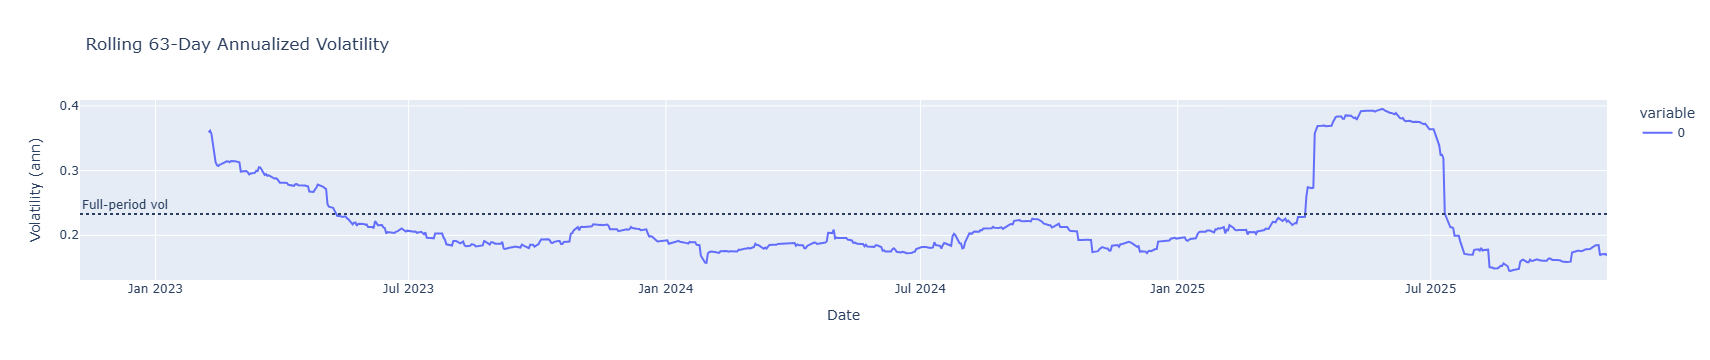

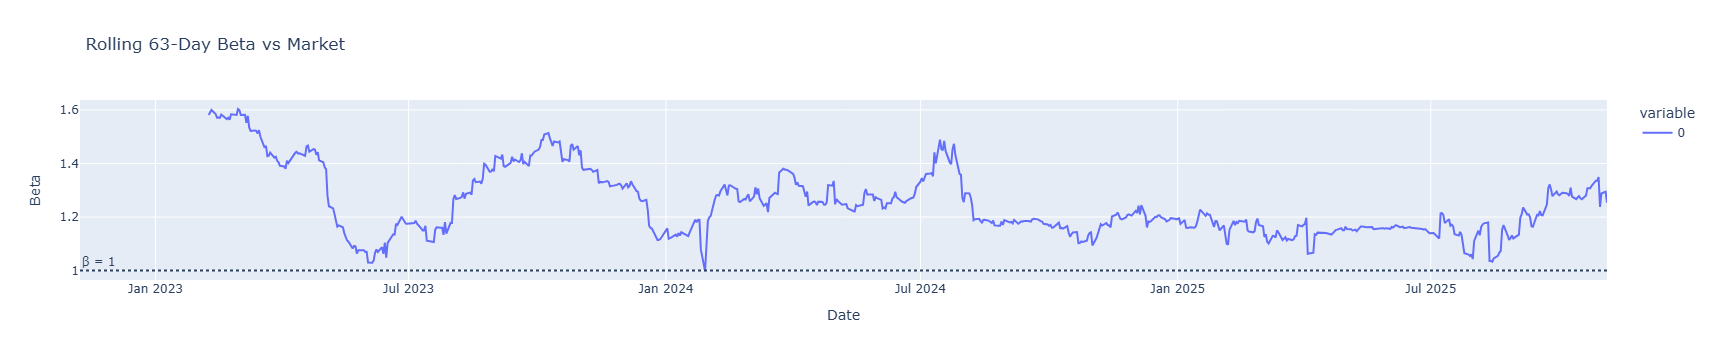

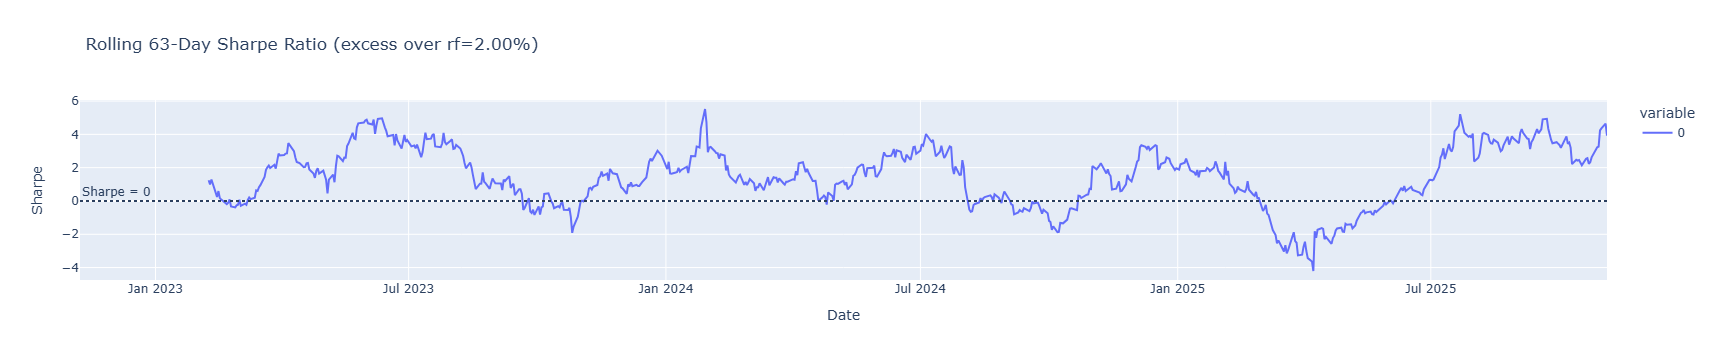

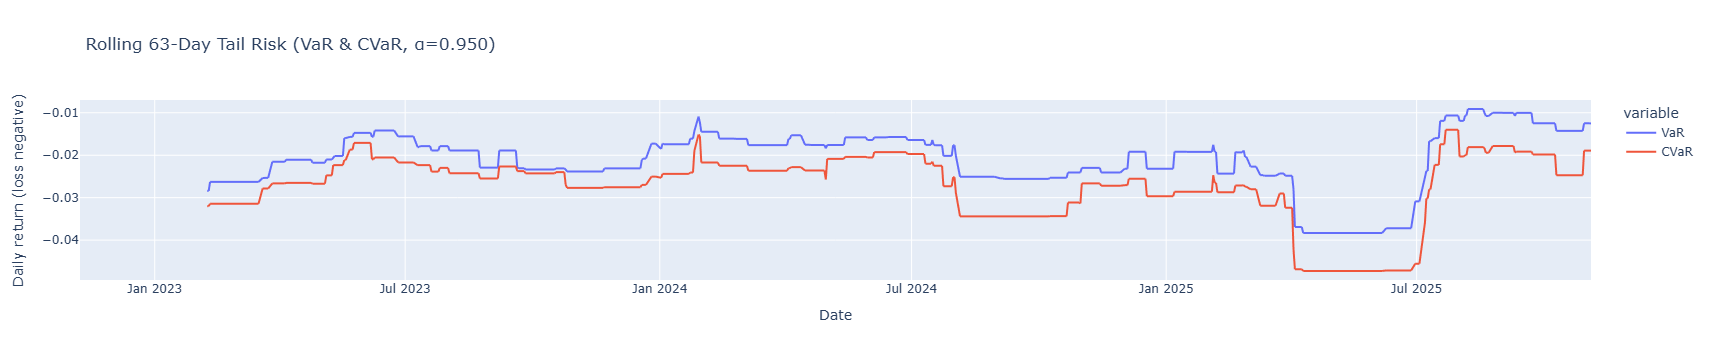

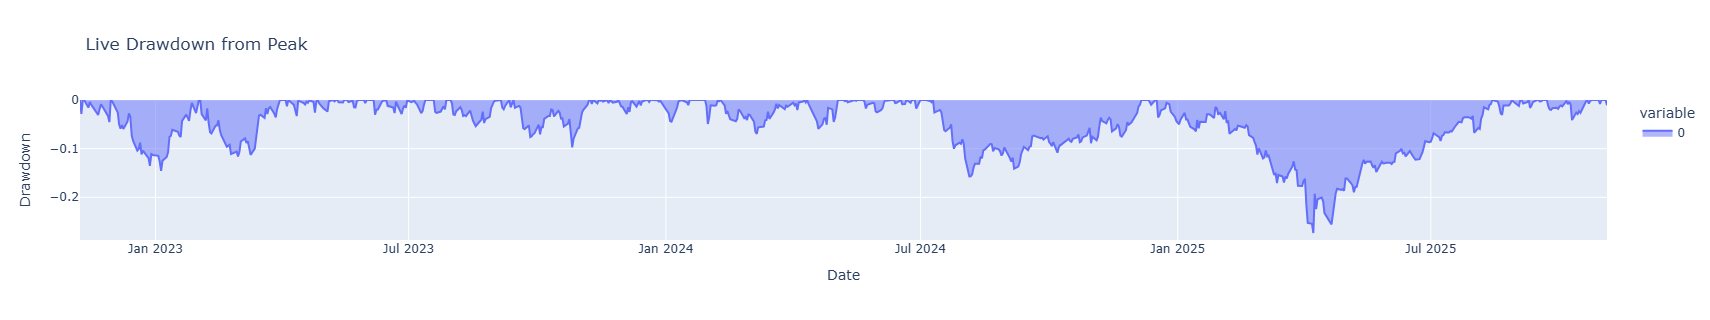

In [4]:
from ipywidgets import IntSlider, Button, HBox, VBox, HTML
import numpy as np
import pandas as pd
import plotly.express as px

# --- Safety checks ---
assert _returns is not None, "Click 'Refresh Data' in the dashboard first."
assert _market_ret is not None, "Market returns not found. Re-run Cell 4."

# --- Controls ---
window_slider = IntSlider(value=63, min=21, max=252, step=7, description="Window (days)")
compute_btn = Button(description="Compute Rolling Risk", button_style="info")
export_btn = Button(description="Export Rolling Charts (HTML)", button_style="success")
rolling_status = HTML(value="")

display(HBox([window_slider, compute_btn, export_btn]), rolling_status)

# --- Helper for CVaR on numpy arrays ---
def _cvar(arr, alpha):
    q = np.quantile(arr, 1 - alpha)
    tail = arr[arr <= q]
    return tail.mean() if tail.size else np.nan

def _rolling_risk(*_):
    rolling_status.value = "<i>Computing…</i>"

    # Use current portfolio weights from the dashboard
    w = _compute_weights()
    port_daily = (_returns * w.values).sum(axis=1).dropna()
    aligned_market = _market_ret.reindex(port_daily.index).dropna()
    port_daily = port_daily.loc[aligned_market.index]  # align again just in case

    window = int(window_slider.value)
    alpha = float(alpha_slider.value)
    rf_ann = float(rf_input.value)
    rf_daily = rf_ann / 252.0

    # Rolling metrics
    roll_std = port_daily.rolling(window).std()
    roll_vol = roll_std * np.sqrt(252)
    roll_mean = port_daily.rolling(window).mean()
    roll_sharpe = ((roll_mean - rf_daily) / roll_std) * np.sqrt(252)
    roll_beta = port_daily.rolling(window).cov(aligned_market).div(
        aligned_market.rolling(window).var()
    )

    # Rolling tail risk
    roll_var = port_daily.rolling(window).apply(lambda a: np.quantile(a, 1 - alpha), raw=True)
    roll_cvar = port_daily.rolling(window).apply(lambda a: _cvar(a, alpha), raw=True)

    # Current drawdown (not rolling max drawdown, but live drawdown path)
    equity = (1 + port_daily).cumprod()
    drawdown = equity / equity.cummax() - 1.0

    # Reference lines for context
    cov = _returns.cov()
    vol_ann, ret_ann, sharpe_ann = portfolio_stats(w.values, cov, mean_ret=_returns.mean(), rf=rf_ann)

    # --- FIGURES ---
    fig_vol = px.line(roll_vol, title=f"Rolling {window}-Day Annualized Volatility")
    fig_vol.add_hline(y=vol_ann, line_dash="dot", annotation_text="Full-period vol", annotation_position="top left")
    fig_vol.update_layout(height=360, yaxis_title="Volatility (ann)")

    fig_beta = px.line(roll_beta, title=f"Rolling {window}-Day Beta vs Market")
    fig_beta.add_hline(y=1.0, line_dash="dot", annotation_text="β = 1", annotation_position="top left")
    fig_beta.update_layout(height=360, yaxis_title="Beta")

    fig_sharpe = px.line(roll_sharpe, title=f"Rolling {window}-Day Sharpe Ratio (excess over rf={rf_ann:.2%})")
    fig_sharpe.add_hline(y=0.0, line_dash="dot", annotation_text="Sharpe = 0", annotation_position="top left")
    fig_sharpe.update_layout(height=360, yaxis_title="Sharpe")

    # VaR/CVaR: note these are typically negative numbers (loss quantiles)
    df_tail = pd.DataFrame({"VaR": roll_var, "CVaR": roll_cvar})
    fig_tail = px.line(df_tail, title=f"Rolling {window}-Day Tail Risk (VaR & CVaR, α={alpha:.3f})")
    fig_tail.update_layout(height=360, yaxis_title="Daily return (loss negative)")

    fig_dd = px.area(drawdown, title="Live Drawdown from Peak")
    fig_dd.update_layout(height=320, yaxis_title="Drawdown")

    # Show the figures
    display(fig_vol)
    display(fig_beta)
    display(fig_sharpe)
    display(fig_tail)
    display(fig_dd)

    rolling_status.value = (
        f"<b>Done.</b> Window={window}d · Full-period vol={vol_ann:.2%} · "
        f"Full-period Sharpe={sharpe_ann:.2f}"
    )

    # Stash for export
    _rolling_risk._figs = [fig_vol, fig_beta, fig_sharpe, fig_tail, fig_dd]

def _export_rolling(*_):
    """Export the rolling charts to a single HTML page."""
    if not hasattr(_rolling_risk, "_figs"):
        rolling_status.value = "<b style='color:red'>Nothing to export yet—click 'Compute Rolling Risk' first.</b>"
        return
    from pathlib import Path
    out = Path("rolling_risk_report.html")
    with open(out, "w", encoding="utf-8") as f:
        f.write("<html><head><meta charset='utf-8'><title>Rolling Risk Report</title></head><body>")
        f.write(f"<h2>Rolling Risk Report</h2><p>Window={window_slider.value} days</p>")
        for fig in _rolling_risk._figs:
            f.write(fig.to_html(full_html=False, include_plotlyjs="cdn"))
        f.write("</body></html>")
    rolling_status.value = f"<b>Exported:</b> {out.resolve()}"

# Bind buttons
compute_btn.on_click(_rolling_risk)
export_btn.on_click(_export_rolling)

# Auto-run once so you see results immediately
_rolling_risk()